In [0]:

!tar xjf /content/drive/My\ Drive/infoleg_conll_auto.tar.bz2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
import re
from collections import defaultdict
from nltk import sent_tokenize
from tqdm import tqdm_notebook

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/infoleg_annotations/"

In [0]:
def conll_iterator(file):
    context = []
    with open(file, "r") as fh:
      for line in fh:
          if line.strip() == "":
              yield context
              context = []
          else:
              (token, lemma, pos, dep, head, tipo) = line.strip().split()
              context.append({
                  "token": token,
                  "lemma": lemma,
                  "pos": pos,
                  "dep": dep,
                  "head": head,
                  "tipo": tipo
              })


In [0]:
entities_features = {}
entity = ""
entities = []
for r, d, f in os.walk(path):
  for file in f:
    try:
      for context in conll_iterator(path+file):
        for idx, word in enumerate(context):
          lemma = word["lemma"]
          if word["tipo"] != "O" and word["tipo"] != "Misc":
            if entity != "":
              entity = entity + " " + lemma
            else:
              entity = lemma
          else:
            if entity != "":
              entities.append(entity)
              entity = ""

      for item in entities:

        if item in entities_features:
          item_feature = entities_features[item]
          for cooc in entities:
            if cooc in item_feature:
              item_feature[cooc] +=1
            else:
              item_feature[cooc] = 1
        else:
          item_feature = {}
          for cooc in entities:
            if cooc in item_feature:
              item_feature[cooc] += 1
            else:
              item_feature[cooc] = 1

        entities_features[item] = item_feature
      entities = []
    except:
      print(file)

175674.conll
215033.conll
43439.conll
95616.conll


In [0]:
word_to_index = {word: idx for idx, word in enumerate(sorted(entities_features.keys()))}
word_features_list = [entities_features[w] for w in sorted(entities_features.keys())]

In [0]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
words_matrix = vectorizer.fit_transform(word_features_list)

dense = DictVectorizer(sparse = False)
word_matrix = dense.fit_transform(word_features_list)

In [0]:
vectorizer.feature_names_[:10]


['12.945 ,',
 '17063',
 '18.586 ,',
 '194/2000',
 '2 de lo ley 11.545y',
 'ANEXO',
 'ANEXO I',
 'ANEXO I ,',
 'ANEXO I - MERCOSUL / GMC / RES Nº 89/96',
 'ANEXO II - MERCOSUL / GMC / RES Nº 90/96']

In [0]:
word_matrix.shape

(13798, 13798)

In [0]:
matrix_normed = word_matrix / word_matrix.max(axis=0)
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))
threshold_v = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)

In [0]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=20)
clusters = model.fit(red_matrix)

In [0]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [0]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[word_to_index[word]])
            for word in word_to_index
        ]
    ],
    columns=["word", "x", "y"]
)

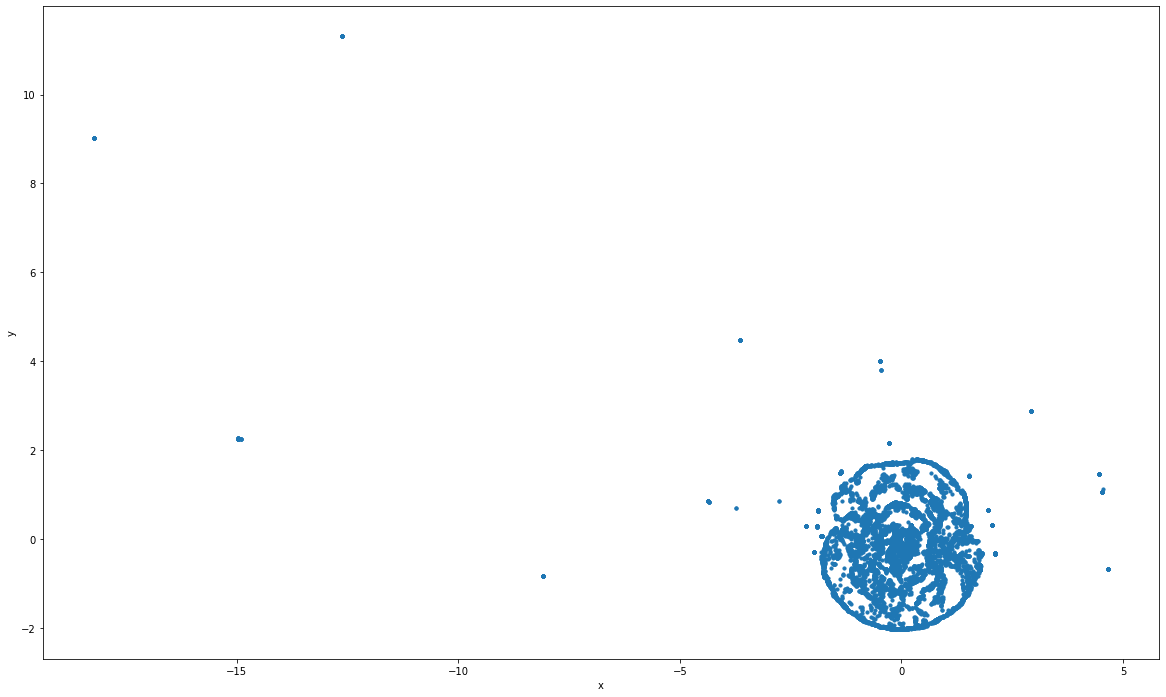

In [0]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [0]:
clusters_per_word = list(zip(sorted(word_to_index.keys()), clusters.labels_))
clusters_per_word[word_to_index['"']][1]

KeyError: ignored

In [0]:

pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[word_to_index[word]], clusters_per_word[word_to_index[word]][1])
            for word in word_to_index
        ]
    ],
    columns=["word", "x", "y", "c"]
)

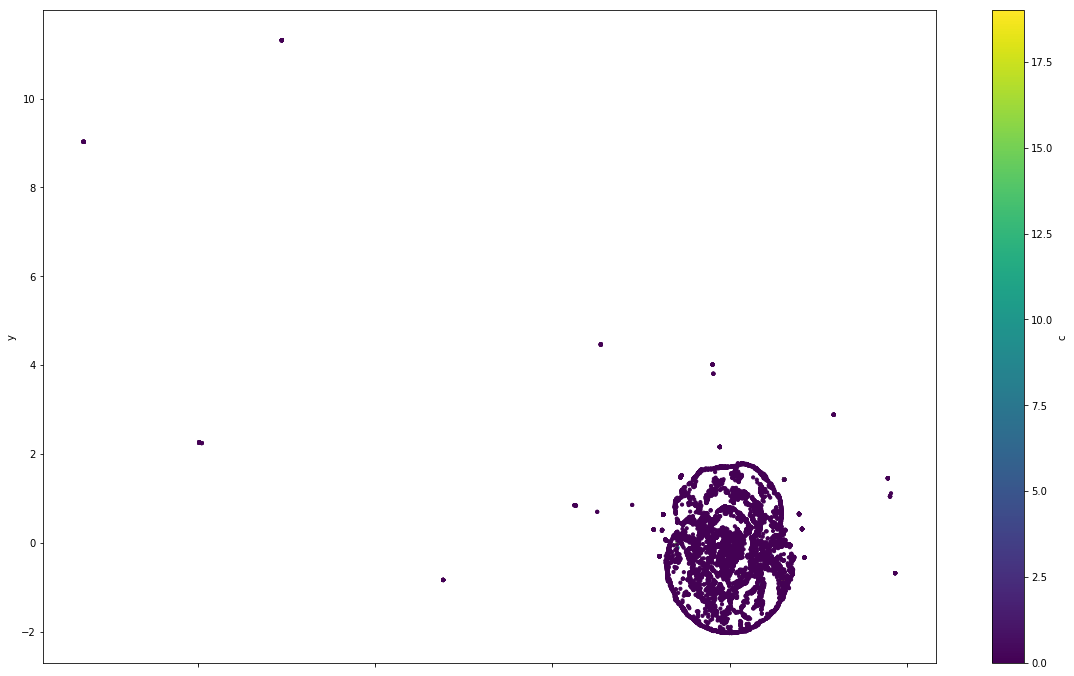

In [0]:
pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

In [0]:
printer_dic={}
for word in word_to_index:
    if clusters_per_word[word_to_index[word]][1] not in printer_dic:
        printer_dic[clusters_per_word[word_to_index[word]][1]] = [word]
    else:
        printer_dic[clusters_per_word[word_to_index[word]][1]].append(word)
for key in sorted(printer_dic.keys()) :
    print(key , " :: " , printer_dic[key])

0  ::  ['12.945 ,', '17063', '18.586 ,', '194/2000', '2 de lo ley 11.545y', 'ANEXO', 'ANEXO I', 'ANEXO I ,', 'ANEXO I - MERCOSUL / GMC / RES Nº 89/96', 'ANEXO II - MERCOSUL / GMC / RES Nº 90/96', 'ANEXO III', 'ANEXO III - MERCOSUL / GMC / RES Nº 91/96', 'ANEXO IV', 'ANEXO IV - MERCOSUL / GMC / RES Nº 92/96', 'ANEXO IX - MERCOSUL / GMC / RES Nº 99/96', 'ANEXO V', 'ANEXO V - MERCOSUL / GMC / RES Nº 93/96', 'ANEXO VI - MERCOSUL / GMC / RES Nº 94/96 (', 'ANEXO VII - MERCOSUL / GMC / RES Nº 95/96', 'ANEXO VIII - MERCOSUL / GMC / RES Nº 98/96', 'ANEXO X - MERCOSUL / GMC / RES Nº 100/96', 'ANEXO XI - MERCOSUL / GMC / RES Nº 101/96', 'ANEXO XII - MERCOSUL / GMC / RES Nº 105/96', 'ANEXO XIII - MERCOSUL / GMC / RES Nº 106/96', 'ANEXO XIV - MERCOSUL / GMC / RES Nº 107/96', 'ANEXO XLI - MERCOSUL / GMC / RES Nº 48/05 ANEXO XLII - MERCOSUL / GMC / RES Nº 49/05 ANEXO XLIII - MERCOSUL / GMC / RES Nº 50/05 ANEXO XLIV - MERCOSUL / GMC / RES Nº 51/05', 'ANEXO XLIX - MERCOSUL / GMC / RES Nº 56/05', 'ANEXO

In [0]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

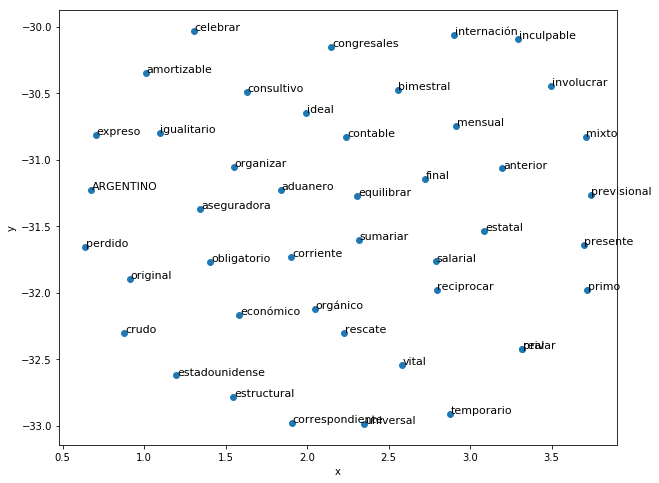

In [0]:
plot_region(x_bounds=(0, 5), y_bounds=(-35, -30))